In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols

### Statistical Analysis Notebook-

What categories are significant in correlation to the popularity of a board game?

In [2]:
# Read in csvs
bgame_df = pd.read_csv('test_this_is_it.csv', delimiter =',')
rank_df = pd.read_csv('test_bgg_dataset.csv', delimiter = ';')

# Display the first few rows
print(bgame_df.columns)
print(rank_df.columns)

Index(['Name', 'Min Players', 'Max Players', 'Play Time', 'Min Age',
       'Users Rated', 'Rating Average', 'Complexity Average', 'Owned Users',
       'Domain1', 'above_average', 'Bayesian Average', 'Most Notable Genre',
       'Most Notable Mechanic', 'Price', 'pct_rated', 'bayes_above_average',
       'Year Published', 'Year Offset', 'Owned_Per_Year'],
      dtype='object')
Index(['ID', 'Name', 'Year Published', 'Min Players', 'Max Players',
       'Play Time', 'Min Age', 'Users Rated', 'Rating Average', 'BGG Rank',
       'Complexity Average', 'Owned Users', 'Mechanics', 'Domains'],
      dtype='object')


In [3]:
# Merge dataframes with suffixes for duplicate columns
merged_df = pd.merge(bgame_df, rank_df, on='Name', how='outer', suffixes=('_x', '_y'))

# Identify and drop the '_y' columns
for col in merged_df.columns:
    if col.endswith('_y'):
        base_col = col[:-2]  # Base column name without suffix
        if base_col + '_x' in merged_df.columns:
            merged_df.drop(columns=[col], inplace=True)

# Optionally, rename the '_x' columns to their original names
merged_df.columns = merged_df.columns.str.replace('_x', '')

# Drop all rows with any NaN values
merged_df.dropna(inplace=True)

# Drop duplicate rows
merged_df = merged_df.drop_duplicates()

# Display the first few rows
print(merged_df.head())

                                Name  Min Players  Max Players  Play Time  \
0                         Gloomhaven          1.0          4.0      120.0   
1          Pandemic Legacy: Season 1          2.0          4.0       60.0   
2                  Brass: Birmingham          2.0          4.0      120.0   
3                  Terraforming Mars          1.0          5.0      120.0   
4  Twilight Imperium: Fourth Edition          3.0          6.0      480.0   

   Min Age  Users Rated  Rating Average  Complexity Average  Owned Users  \
0     14.0      42055.0            8.79                3.86      68323.0   
1     13.0      41643.0            8.61                2.84      65294.0   
2     14.0      19217.0            8.66                3.91      28785.0   
3     12.0      64864.0            8.43                3.24      87099.0   
4     14.0      13468.0            8.70                4.22      16831.0   

          Domain1  ...   Price  pct_rated bayes_above_average Year Published  \


In [4]:
# Export the cleaned DataFrame to a CSV file
merged_df.to_csv('statistical_analysis_final_csv.csv', index=False)

In [5]:
len(merged_df)

11144

In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11144 entries, 0 to 23293
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   11144 non-null  object 
 1   Min Players            11144 non-null  float64
 2   Max Players            11144 non-null  float64
 3   Play Time              11144 non-null  float64
 4   Min Age                11144 non-null  float64
 5   Users Rated            11144 non-null  float64
 6   Rating Average         11144 non-null  float64
 7   Complexity Average     11144 non-null  float64
 8   Owned Users            11144 non-null  float64
 9   Domain1                11144 non-null  object 
 10  above_average          11144 non-null  object 
 11  Bayesian Average       11144 non-null  float64
 12  Most Notable Genre     11144 non-null  object 
 13  Most Notable Mechanic  11144 non-null  object 
 14  Price                  11144 non-null  float64
 15  pc

In [7]:
# Converting BGG Rank from int to float
merged_df['BGG Rank'] = merged_df['BGG Rank'].astype(float)

In [8]:
unique_domain = merged_df['Domain1'].unique()
print(unique_domain)

['Strategy Games' 'Thematic Games' 'Family Games' 'Customizable Games'
 'Abstract Games' 'Party Games' 'Wargames' 'other' "Children's Games"]


In [48]:
unique_domain_info = merged_df['Domain1'].value_counts()
print(unique_domain_info)

Wargames              3337
Family Games          2043
Strategy Games        1991
Abstract Games        1101
Thematic Games         854
Children's Games       738
Party Games            444
other                  377
Customizable Games     259
Name: Domain1, dtype: int64


In [9]:
unique_genre = merged_df['Most Notable Genre'].unique()
print(unique_genre)

['Adventure' 'Environmental' 'Age of Reason' 'Economic' 'Civilization'
 'Card Game' 'Civil War' 'Modern Warfare' 'American West' 'Fantasy' 'Dice'
 'Ancient' 'Animals' 'Medieval' 'City Building' 'Abstract Strategy'
 'Bluffing' 'Action / Dexterity' 'Arabian' 'Industry / Manufacturing'
 'Renaissance' 'Deduction' 'Medical' 'Science Fiction' 'Aviation / Flight'
 'Exploration' 'Trains' 'Post-Napoleonic' 'Miniatures' 'Wargame'
 'Party Game' 'Movies / TV / Radio theme' 'Horror' 'Real-time' 'Racing'
 'unspecified' 'Not available' 'Humor' 'Maze' 'Spies/Secret Agents'
 'Collectible Components' 'Nautical' 'Fighting' 'Prehistoric'
 'Educational' "Children's Game" 'Math' 'Travel' 'Mythology' 'Negotiation'
 'Political' 'Napoleonic' 'Farming' 'Transportation' 'Territory Building'
 'American Civil War' 'Parsing Error' 'American Indian Wars'
 'Comic Book / Strip' 'Mafia' 'Electronic' 'Puzzle' 'Murder/Mystery'
 'Pirates' 'Novel-based' 'Sports' 'Korean War' 'Print & Play' 'Book'
 'American Revolutionary W

In [10]:
# Group by 'Domain1' and aggregate 'Most Notable Genre'
grouped_genres = merged_df.groupby('Domain1')['Most Notable Genre'].unique()

# Create a DataFrame from the grouped genres
grouped_genres_df = grouped_genres.reset_index()

# Add a new column 'Total Genres' which is length of each unique genre list
grouped_genres_df['Total Genres'] = grouped_genres_df['Most Notable Genre'].apply(len)

# Print the result
grouped_genres_df

,Domain1,Most Notable Genre,Total Genres
0,Abstract Games,"[Abstract Strategy, Dice, unspecified, Card Ga...",31
1,Children's Games,"[Children's Game, Action / Dexterity, Adventur...",24
2,Customizable Games,"[Adventure, Card Game, Bluffing, Aviation / Fl...",16
3,Family Games,"[Animals, Card Game, Ancient, Adventure, Medie...",68
4,Party Games,"[Card Game, Deduction, Bluffing, Party Game, u...",34
5,Strategy Games,"[Adventure, Environmental, Age of Reason, Econ...",66
6,Thematic Games,"[Civil War, Fantasy, Adventure, Bluffing, Dedu...",53
7,Wargames,"[Ancient, Adventure, Fantasy, Miniatures, Warg...",54
8,other,"[Not available, Card Game, Party Game, Racing,...",33


In [11]:
# Checking each unique mechanic
unique_mechanic = merged_df['Most Notable Mechanic'].unique()
print(unique_mechanic)

['Action Queue' 'Action Points' 'Hand Management' 'Closed Drafting'
 'Action Drafting' 'End Game Bonuses' 'Area Majority / Influence'
 'Action/Event' 'Deck, Bag, and Pool Building' 'Action Retrieval'
 'Dice Rolling' 'Automatic Resource Growth' 'Contracts'
 'Campaign / Battle Card Driven' 'Card Play Conflict Resolution'
 'Delayed Purchase' 'Area Movement' 'Cooperative Game'
 'Auction: Turn Order Until Pass' 'Bias' 'Communication Limits'
 'Commodity Speculation' 'Not available' 'Follow' 'Catch the Leader'
 'Flicking' 'Auction/Bidding' 'Chit-Pull System'
 'Auction: Fixed Placement' 'Enclosure' 'Grid Coverage' 'Bingo'
 'Connections' 'Finale Ending' 'Advantage Token' 'Alliances'
 'Increase Value of Unchosen Resources' 'Variable Player Powers'
 'Auction: Dutch' 'Events' 'Betting and Bluffing' 'Grid Movement'
 'Auction: Once Around' 'Hidden Roles' 'unspecified' 'Deduction' 'Acting'
 'Investment' 'Open Drafting' 'Tile Placement'
 'Narrative Choice / Paragraph' 'Pattern Recognition' 'Trick-taki

In [12]:
# Group by 'Domain1' and aggregate 'Most Notable Genre'
grouped_mechanics = merged_df.groupby('Domain1')['Most Notable Mechanic'].unique()

# Convert to DataFrame
grouped_mechanics_df = grouped_mechanics.reset_index()

# Add a new column 'Total Mechanics' which is length of each unique genre list
grouped_mechanics_df['Total Mechanics'] = grouped_mechanics_df['Most Notable Mechanic'].apply(len)


# Print the result
grouped_mechanics_df

,Domain1,Most Notable Mechanic,Total Mechanics
0,Abstract Games,"[End Game Bonuses, Not available, Grid Coverag...",67
1,Children's Games,"[Dice Rolling, Area Movement, Hand Management,...",57
2,Customizable Games,"[Action Points, Card Play Conflict Resolution,...",33
3,Family Games,"[Action Queue, Contracts, Communication Limits...",107
4,Party Games,"[Communication Limits, Finale Ending, Grid Mov...",61
5,Strategy Games,"[Action Queue, Action Points, Hand Management,...",101
6,Thematic Games,"[Area Majority / Influence, Action Drafting, C...",53
7,Wargames,"[Dice Rolling, Area Majority / Influence, Camp...",47
8,other,"[Not available, Trick-taking, Acting, Push You...",36


In [13]:
domain_stats = merged_df.groupby('Domain1').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='Owned Users', ascending=False)

# Display the result
print(domain_stats)

                    Rating Average      BGG Rank  Owned Users  Users Rated
Domain1                                                                   
Family Games              6.439266   5837.447381    9200902.0    5871528.0
Strategy Games            7.015590   3620.482672    9065100.0    6409811.0
Thematic Games            6.864016   4763.367681    3587189.0    2096762.0
Party Games               6.341959   6862.637387    2391372.0    1418746.0
Wargames                  6.827402   9496.648487    1976890.0     772733.0
Abstract Games            6.220772  10178.762943    1629591.0    1043234.0
Customizable Games        6.517220   8084.270270     658847.0     381007.0
Children's Games          5.528808  14113.590786     577613.0     314463.0
other                     5.909284   8315.771883     121813.0      52706.0


In [14]:
domain_stats = merged_df.groupby('Domain1').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='BGG Rank', ascending=True)

# Display the result
print(domain_stats)

                    Rating Average      BGG Rank  Owned Users  Users Rated
Domain1                                                                   
Strategy Games            7.015590   3620.482672    9065100.0    6409811.0
Thematic Games            6.864016   4763.367681    3587189.0    2096762.0
Family Games              6.439266   5837.447381    9200902.0    5871528.0
Party Games               6.341959   6862.637387    2391372.0    1418746.0
Customizable Games        6.517220   8084.270270     658847.0     381007.0
other                     5.909284   8315.771883     121813.0      52706.0
Wargames                  6.827402   9496.648487    1976890.0     772733.0
Abstract Games            6.220772  10178.762943    1629591.0    1043234.0
Children's Games          5.528808  14113.590786     577613.0     314463.0


In [15]:
genre_stats = merged_df.groupby('Most Notable Genre').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='Owned Users', ascending=False)

# Display the result
print(genre_stats)

                         Rating Average      BGG Rank  Owned Users  \
Most Notable Genre                                                   
Card Game                      6.421101   6759.868207    4567253.0   
unspecified                    7.560862    723.060345    3907112.0   
Bluffing                       6.678554   4656.891566    2775321.0   
Adventure                      6.682907   5734.043783    2355113.0   
Abstract Strategy              6.224676  10000.919964    1673892.0   
...                                 ...           ...          ...   
Space Exploration              6.860000   4329.000000       2134.0   
Music                          6.755000   7184.500000       1089.0   
Number                         4.210000  19199.500000        658.0   
Expansion for Base-game        7.473333  10610.000000        492.0   
World War II                   6.580000   5096.000000        436.0   

                         Users Rated  
Most Notable Genre                    
Card Game  

In [16]:
genre_stats = merged_df.groupby('Most Notable Genre').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='BGG Rank', ascending=True)

# Display the result
print(genre_stats)

                     Rating Average      BGG Rank  Owned Users  Users Rated
Most Notable Genre                                                         
unspecified                7.560862    723.060345    3907112.0    2714764.0
Spies/Secret Agents        7.280000   1061.000000       9545.0       5659.0
Travel                     6.970000   1983.000000      30586.0      21109.0
Environmental              7.201250   2476.500000     164357.0      96548.0
Video Game Theme           6.970000   2807.000000       3169.0       1487.0
...                             ...           ...          ...          ...
Post-Napoleonic            6.718816  10727.407895     101250.0      64319.0
Mature / Adult             5.595000  11891.500000       3142.0       1149.0
Children's Game            5.534406  14184.005797     374701.0     198743.0
Trivia                     5.381667  15470.500000       3651.0       1485.0
Number                     4.210000  19199.500000        658.0        803.0

[84 rows x 

In [17]:
mech_stats = merged_df.groupby('Most Notable Mechanic').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='Owned Users', ascending=False)

# Display the result
print(mech_stats)

                           Rating Average      BGG Rank  Owned Users  \
Most Notable Mechanic                                                  
unspecified                      7.560862    723.060345    3907112.0   
Dice Rolling                     6.590722   9159.734065    2857401.0   
Hand Management                  6.312716   7243.904429    2500574.0   
Area Majority / Influence        6.826418   5085.686761    2376179.0   
Action Points                    7.010941   5407.751037    2262824.0   
...                                   ...           ...          ...   
Measurement Movement             7.377500   9507.000000        632.0   
Turn Order: Time Track           7.130000   2856.000000        520.0   
Once-Per-Game Abilities          6.400000   7304.000000        468.0   
Movement Template                7.315000   8303.500000        446.0   
Pieces as Map                    4.910000  19809.000000        401.0   

                           Users Rated  
Most Notable Mechanic 

In [18]:
mech_stats = merged_df.groupby('Most Notable Mechanic').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='BGG Rank', ascending=True)

# Display the result
print(mech_stats)

                                      Rating Average      BGG Rank  \
Most Notable Mechanic                                                
Finale Ending                               7.580000    131.000000   
Automatic Resource Growth                   7.804286    384.714286   
Increase Value of Unchosen Resources        7.445000    420.500000   
Order Counters                              7.420000    470.000000   
Auction: Once Around                        7.411667    659.166667   
...                                              ...           ...   
Race                                        5.366000  13541.466667   
Roll / Spin and Move                        5.245052  15077.380208   
Matching                                    5.584444  15383.222222   
Pieces as Map                               4.910000  19809.000000   
Auction: English                            4.680000  20188.000000   

                                      Owned Users  Users Rated  
Most Notable Mechanic   

### Boxplots and Outliers

In [19]:
# Function to find number of outliers per group
def find_outliers(group):
    q1 = group.quantile(0.25)
    q3 = group.quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Return outliers
    return group[(group < lower_bound) | (group > upper_bound)]

# Apply this function to each domain for both 'Rating Average' and 'Owned Users'
outliers_rating_avg = merged_df.groupby('Domain1')['Rating Average'].apply(find_outliers)
outliers_owned_users = merged_df.groupby('Domain1')['Owned Users'].apply(find_outliers)

# Apply this function to 'BGG Rank' by 'Domain'
outliers_bgg_rank = merged_df.groupby('Domain1')['BGG Rank'].apply(find_outliers)

# Calculate the number of outliers per domain
outliers_count_rating_avg = outliers_rating_avg.groupby('Domain1').count()
outliers_count_owned_users = outliers_owned_users.groupby('Domain1').count()

# Calculate the number of outliers per domain for 'BGG Rank'
outliers_count_bgg_rank = outliers_bgg_rank.groupby('Domain1').count()

# Display the number of outliers per domain
print("Outliers in Rating Average per Domain:")
print(outliers_count_rating_avg)

print("\nOutliers in Owned Users per Domain:")
print(outliers_count_owned_users)


# Display the number of outliers per domain for 'BGG Rank'
print("Outliers in BGG Rank per Domain:")
print(outliers_count_bgg_rank)

Outliers in Rating Average per Domain:
Domain1
Abstract Games        13
Children's Games       5
Customizable Games     4
Family Games          28
Party Games            8
Strategy Games        17
Thematic Games         5
Wargames              22
other                  7
Name: Rating Average, dtype: int64

Outliers in Owned Users per Domain:
Domain1
Abstract Games        150
Children's Games       91
Customizable Games     35
Family Games          252
Party Games            55
Strategy Games        205
Thematic Games        105
Wargames              290
other                  38
Name: Owned Users, dtype: int64
Outliers in BGG Rank per Domain:
Domain1
Family Games      164
Party Games        47
Strategy Games    134
Thematic Games     63
Name: BGG Rank, dtype: int64


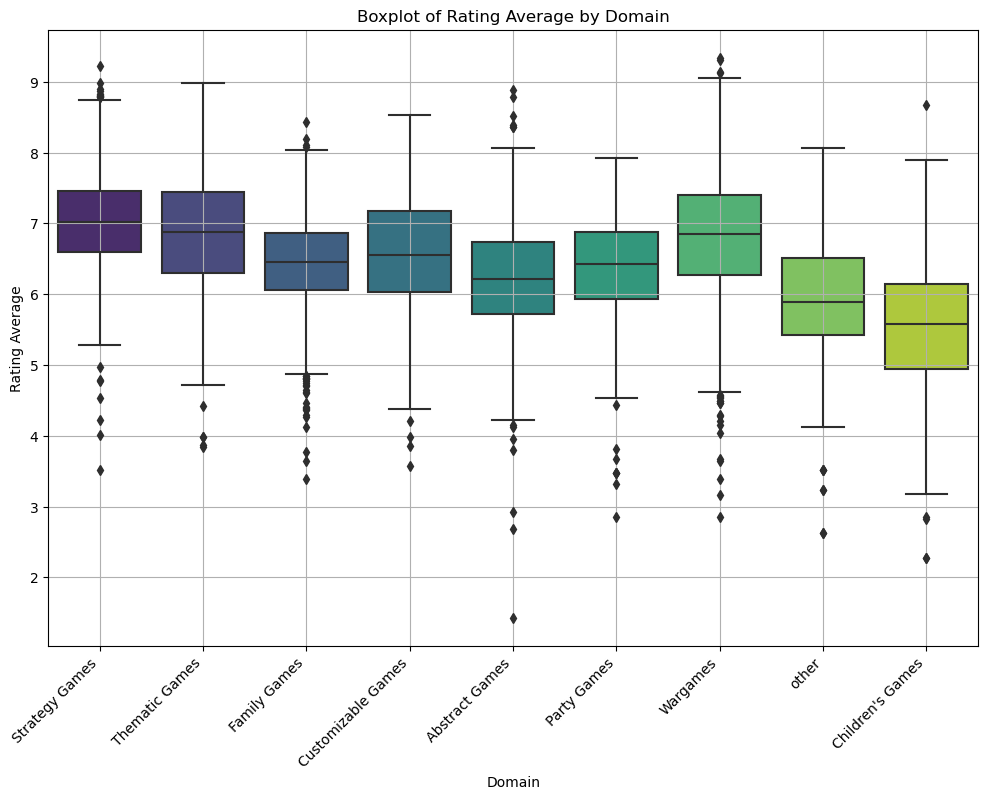

In [20]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Domain1', y='Rating Average', data=merged_df, palette='viridis')

# Rotate x labels for better readability
plt.xticks(rotation=45, ha='right')

# Adding title and labels
plt.title('Boxplot of Rating Average by Domain')
plt.xlabel('Domain')
plt.ylabel('Rating Average')
plt.grid(True)
plt.show()


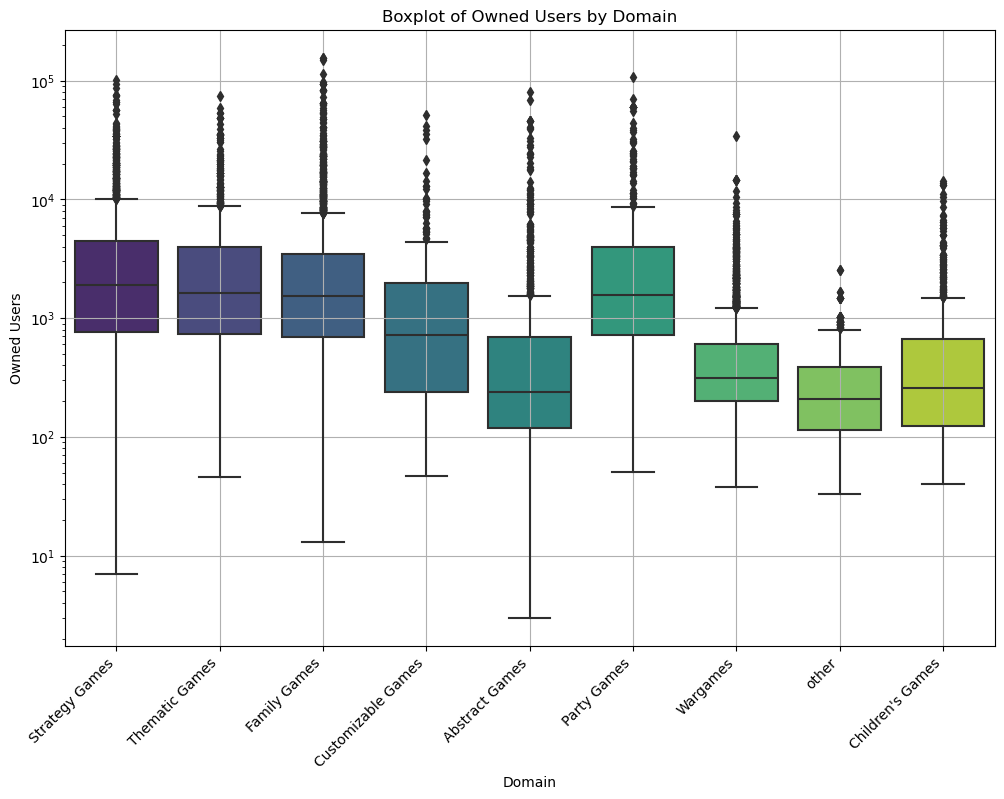

In [21]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Domain1', y='Owned Users', data=merged_df, palette='viridis')

# Rotate x labels for better readability
plt.xticks(rotation=45, ha='right')

# Title and labels
plt.title('Boxplot of Owned Users by Domain')
plt.xlabel('Domain')
plt.ylabel('Owned Users')
plt.yscale('log')  # Use log scale if 'Owned Users' has a large range

plt.grid(True)
plt.show()

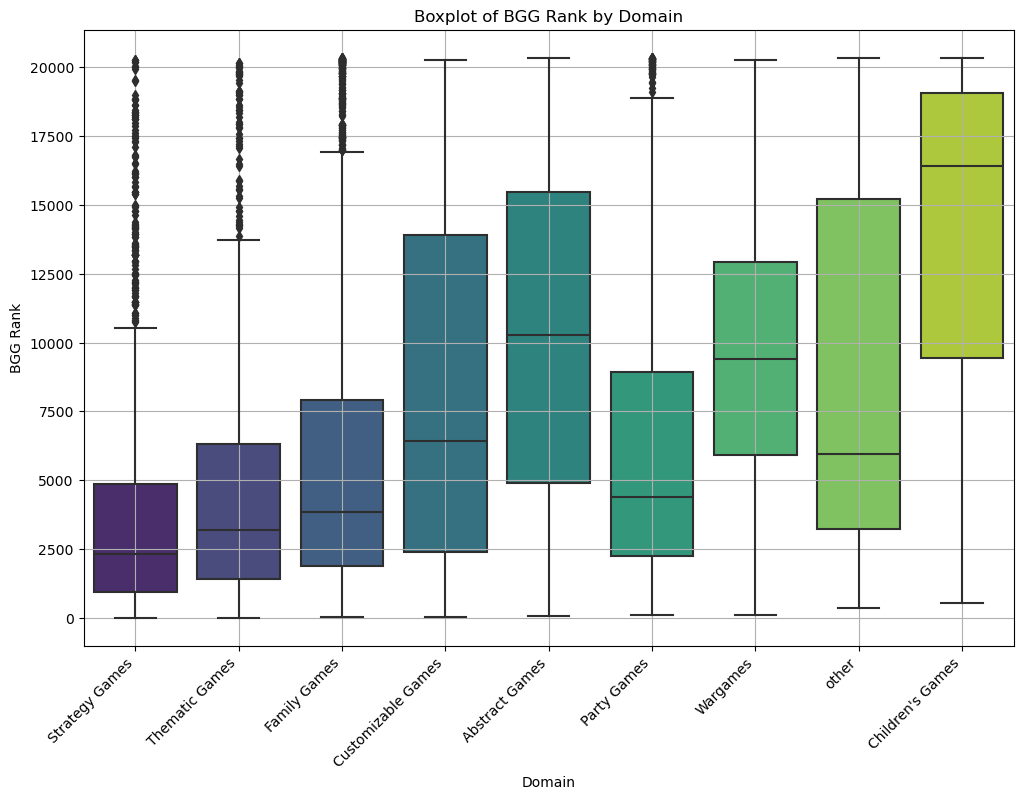

In [22]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Domain1', y='BGG Rank', data=merged_df, palette='viridis')

# Rotate x labels for better readability
plt.xticks(rotation=45, ha='right')

# Title and labels
plt.title('Boxplot of BGG Rank by Domain')
plt.xlabel('Domain')
plt.ylabel('BGG Rank')
#plt.yscale('log')  # Use log scale if 'Owned Users' has a large range

plt.grid(True)
plt.show()

In [23]:
correlation = merged_df['Rating Average'].corr(merged_df['Owned Users'])
print(f"Correlation coefficient between Rating Average and Owned Users: {correlation}")

Correlation coefficient between Rating Average and Owned Users: 0.20136951918061066


### Correlation and Significance

- Shows us correlation and significance between two values

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

def correlation_analysis(df, col1, col2, alpha=0.05):
    """
    This function calculates the correlation between two columns of a DataFrame,
    tests the statistical significance of the correlation (p-value), 
    plots the correlation graph with a regression line, 
    and displays the regression equation.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    col1 (str): The name of the first column.
    col2 (str): The name of the second column.
    alpha (float): The significance level for the p-value (default is 0.05).

    Returns:
    None
    """
    # 1. Calculate correlation
    correlation = df[col1].corr(df[col2])
    print(f"Correlation between {col1} and {col2}: {correlation}")

    # 2. Compute Pearson correlation coefficient and p-value
    corr, p_value = pearsonr(df[col1], df[col2])
    print(f"Pearson Correlation: {corr}")
    print(f"P-value: {p_value}")

    # 3. Check significance of the p-value
    if p_value < alpha:
        print(f"The correlation is statistically significant at alpha={alpha}.")
    else:
        print(f"The correlation is NOT statistically significant at alpha={alpha}.")

    # 4. Perform linear regression to get the line equation
    X = df[col1].values.reshape(-1, 1)  # Predictor (independent variable)
    Y = df[col2].values.reshape(-1, 1)  # Target (dependent variable)
    
    # Linear regression model
    model = LinearRegression()
    model.fit(X, Y)
    
    # Get slope and intercept
    slope = model.coef_[0][0]
    intercept = model.intercept_[0]
    
    # Print the regression line equation
    print(f"Regression Line: Y = {slope:.2f}X + {intercept:.2f}")
    
    # 5. Plot the data with regression line
    sns.regplot(x=col1, y=col2, data=df, line_kws={'color': 'red'}, ci=None)

    # Add the equation as text to the plot
    plt.text(
        0.05, 0.95,  # Coordinates for the text (you might need to adjust this)
        f'Y = {slope:.2f}X + {intercept:.2f}',
        fontsize=12,
        color='red',
        ha='left',
        va='top',
        transform=plt.gca().transAxes
    )

    # Title of the plot with correlation and p-value
    plt.title(f"Correlation between {col1} and {col2}: {corr:.2f}, p-value: {p_value:.4f}")

    # Show the plot
    plt.show()


Correlation between BGG Rank and Rating Average: -0.6574357620481069
Pearson Correlation: -0.6574357620481067
P-value: 0.0
The correlation is statistically significant at alpha=0.05.
Regression Line: Y = -0.00X + 7.32


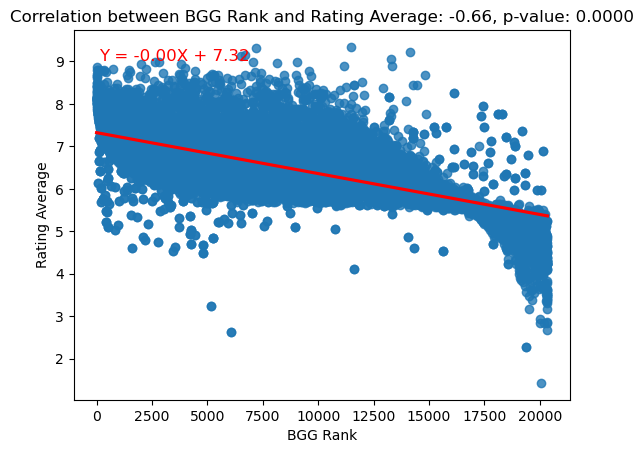

In [25]:
# Correlation between BGG Rank and Rating Average
correlation_analysis(merged_df, 'BGG Rank', 'Rating Average')

Correlation between BGG Rank and Owned Users: -0.3015914789205524
Pearson Correlation: -0.30159147892055244
P-value: 4.6920773238251875e-233
The correlation is statistically significant at alpha=0.05.
Regression Line: Y = -0.38X + 5481.29


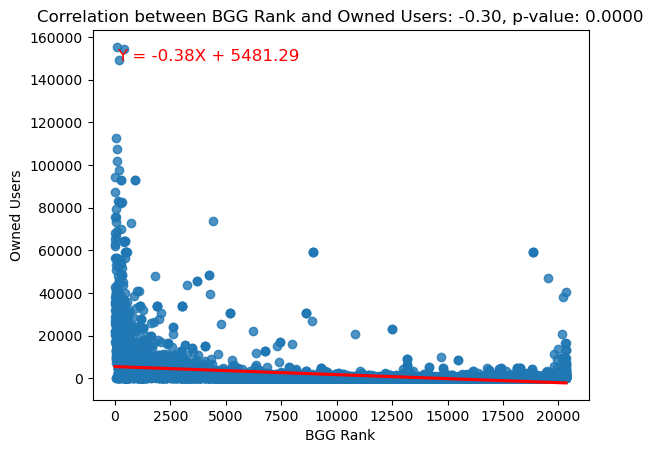

In [26]:
# Correlation between BGG Rank and Rating Average
correlation_analysis(merged_df, 'BGG Rank', 'Owned Users')

### ANOVAS

- Shows us significance between categories and values

In [27]:
def anova_def(df, numeric_col, categorical_col, alpha=0.05):
    """
    This function performs an ANOVA test between a numerical column (BGG Rank) 
    and a categorical column (Domain). It also includes statistical analysis 
    sentences about the significance of the results.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    numeric_col (str): The name of the numerical column (e.g., 'BGG Rank').
    categorical_col (str): The name of the categorical column (e.g., 'Domain').
    alpha (float): The significance level for the p-value (default is 0.05).

    Returns:
    None
    """
    # 1. Temporarily rename the columns to remove spaces or special characters
    df_temp = df.rename(columns={numeric_col: 'NumericCol', categorical_col: 'CategoricalCol'})
    
    # 2. Fit the ANOVA model with the temporary column names
    model = ols('NumericCol ~ C(CategoricalCol)', data=df_temp).fit()
    
    # 3. Perform ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("ANOVA Table:")
    print(anova_table)

    # 4. Extract p-value
    p_value = anova_table['PR(>F)'][0]
    
    # 5. Statistical analysis and significance check
    if p_value < alpha:
        print(f"\nThe p-value ({p_value:.4f}) is less than alpha={alpha}, indicating that there is a statistically significant difference in the means of {numeric_col} across the categories of {categorical_col}.")
    else:
        print(f"\nThe p-value ({p_value:.4f}) is greater than alpha={alpha}, indicating that there is no statistically significant difference in the means of {numeric_col} across the categories of {categorical_col}.")


In [28]:
anova_def(merged_df, 'BGG Rank', 'Domain1')

ANOVA Table:
                         sum_sq       df           F  PR(>F)
C(CategoricalCol)  9.588031e+10      8.0  462.073923     0.0
Residual           2.888140e+11  11135.0         NaN     NaN

The p-value (0.0000) is less than alpha=0.05, indicating that there is a statistically significant difference in the means of BGG Rank across the categories of Domain1.


In [29]:
anova_def(merged_df, 'BGG Rank', 'Most Notable Genre')

ANOVA Table:
                         sum_sq       df         F  PR(>F)
C(CategoricalCol)  6.222218e+10     83.0  25.71166     0.0
Residual           3.224721e+11  11060.0       NaN     NaN

The p-value (0.0000) is less than alpha=0.05, indicating that there is a statistically significant difference in the means of BGG Rank across the categories of Most Notable Genre.


In [30]:
anova_def(merged_df, 'BGG Rank', 'Most Notable Mechanic')

ANOVA Table:
                         sum_sq       df          F  PR(>F)
C(CategoricalCol)  8.573976e+10    147.0  21.453322     0.0
Residual           2.989545e+11  10996.0        NaN     NaN

The p-value (0.0000) is less than alpha=0.05, indicating that there is a statistically significant difference in the means of BGG Rank across the categories of Most Notable Mechanic.


### Grouped Correlation and Significance

- Correlation and significance between values, but including various categories and how well they follow the trend (shows outliers) and to what extent they could potentially affect BGG rank

In [31]:
# Function for analyzing correlation and determining p-values and significance
def analyze_correlation(data, x_col, y_col, hue_col=None, palette='viridis', scatter_size=100, plot_title=None):
    """
    Analyzes the correlation between two columns in a DataFrame and performs significance testing.
    
    Parameters:
    - data: DataFrame containing the data
    - x_col: The name of the column to be used for the x-axis
    - y_col: The name of the column to be used for the y-axis
    - hue_col: The name of the column to be used for color coding (optional)
    - palette: Color palette for the scatter plot
    - scatter_size: Size of scatter plot markers
    - plot_title: Title for the plot
    
    Returns:
    - corr_coefficient: Pearson correlation coefficient
    - p_value: P-value for the significance test
    """
    
    # Scatter plot to visualize the correlation
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x=x_col, y=y_col, hue=hue_col, palette=palette, s=scatter_size)

    # Trend line to the scatter plot
    sns.regplot(data=data, x=x_col, y=y_col, scatter=False, color='blue')

    # Adding labels and title
    if plot_title:
        plt.title(plot_title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    if hue_col:
        plt.legend(title=hue_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

    # Calculate the Pearson correlation coefficient and p-value
    corr_coefficient, p_value = pearsonr(data[x_col], data[y_col])

    # Display the results
    print(f"Pearson Correlation Coefficient: {corr_coefficient}")
    print(f"P-value: {p_value}")

    # Interpret the results
    alpha = 0.05  # significance level
    if p_value < alpha:
        print("The correlation is statistically significant.")
    else:
        print("The correlation is not statistically significant.")
    
    return corr_coefficient, p_value

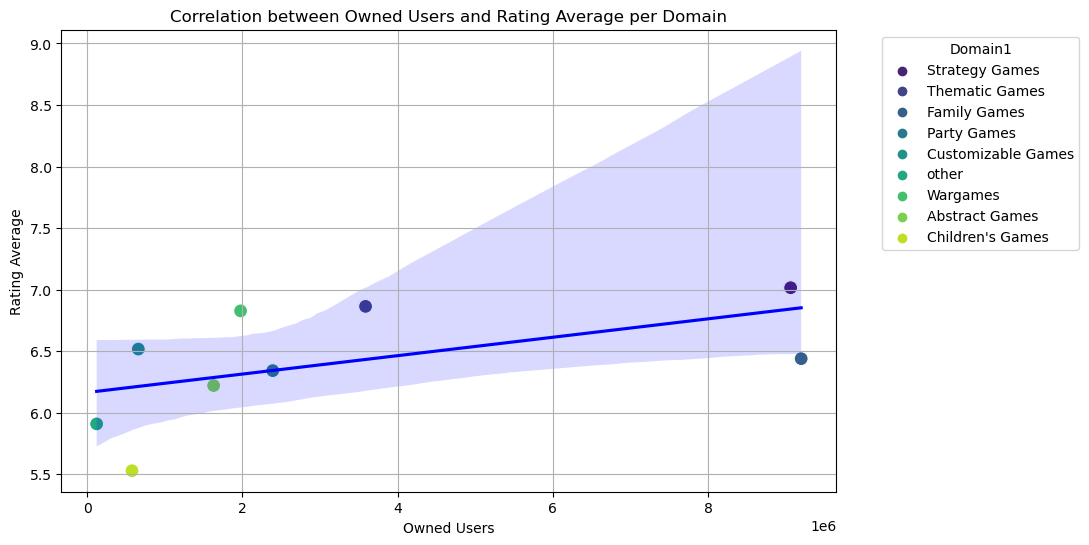

Pearson Correlation Coefficient: 0.5475691319825113
P-value: 0.12699854186835866
The correlation is not statistically significant.


(0.5475691319825113, 0.12699854186835866)

In [32]:
analyze_correlation(
    data=domain_stats, 
    x_col='Owned Users', 
    y_col='Rating Average', 
    hue_col='Domain1', 
    plot_title='Correlation between Owned Users and Rating Average per Domain'
)

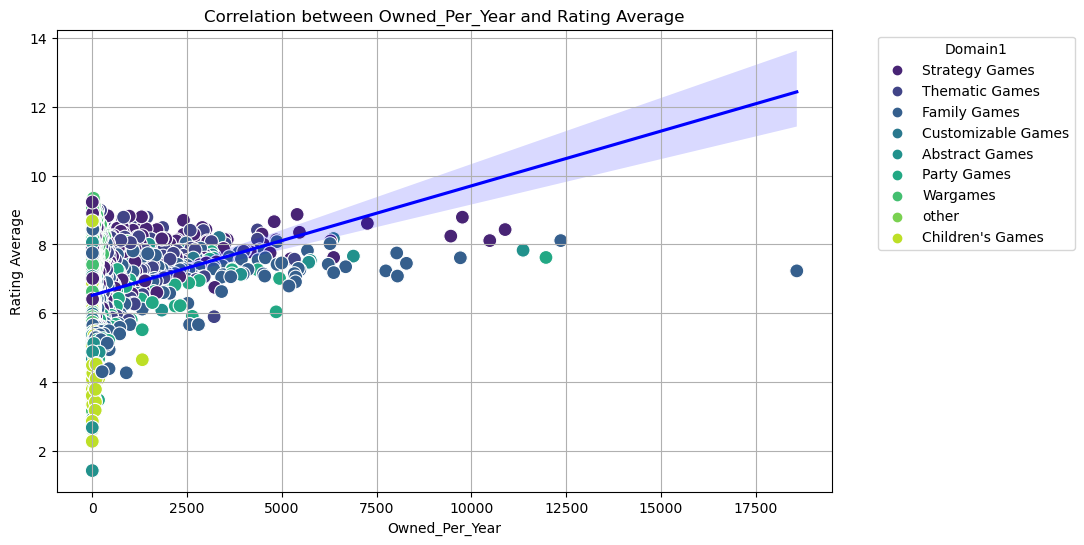

Pearson Correlation Coefficient: 0.25022805438305395
P-value: 1.0891409673782164e-158
The correlation is statistically significant.


(0.25022805438305395, 1.0891409673782164e-158)

In [33]:
analyze_correlation(
    data=merged_df, 
    x_col='Owned_Per_Year', 
    y_col='Rating Average', 
    hue_col='Domain1', 
    plot_title='Correlation between Owned_Per_Year and Rating Average'
)

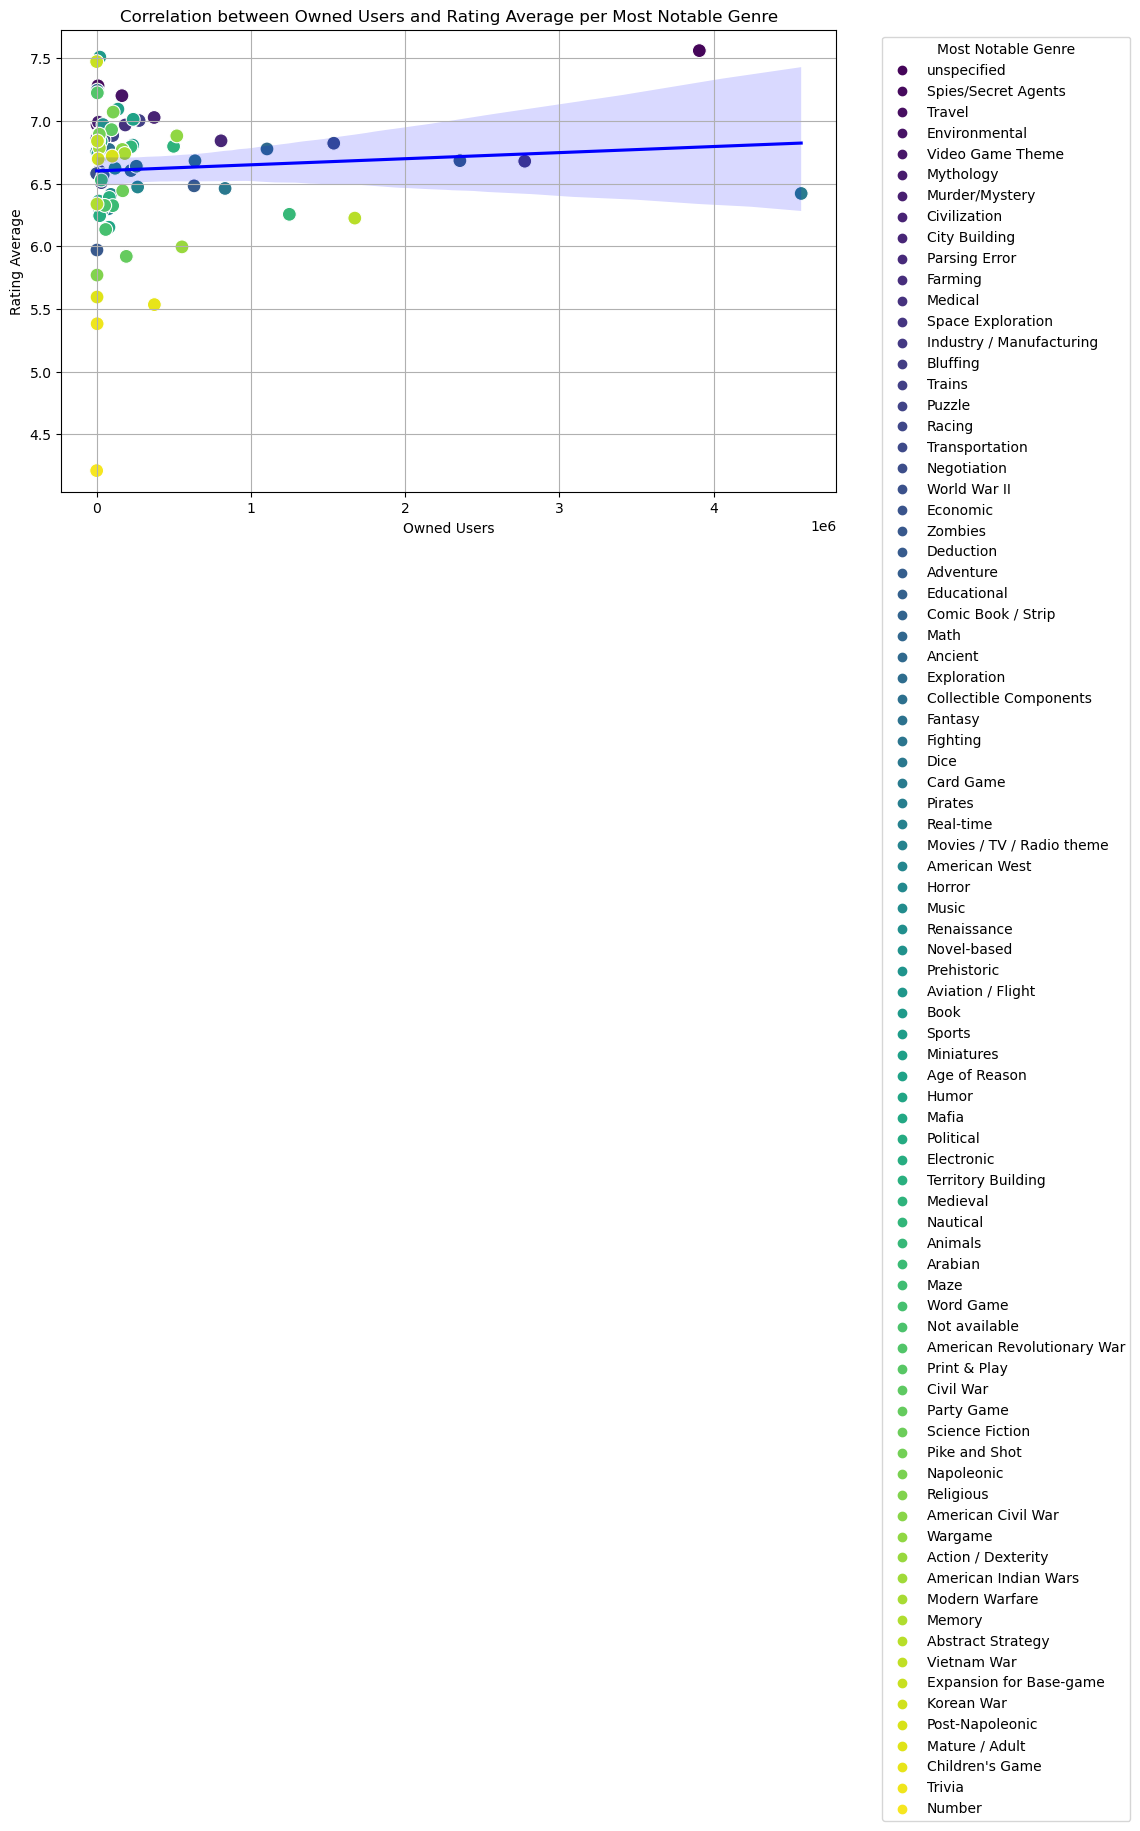

Pearson Correlation Coefficient: 0.07775165115614752
P-value: 0.482059904954414
The correlation is not statistically significant.


(0.07775165115614752, 0.482059904954414)

In [34]:
analyze_correlation(
    data=genre_stats, 
    x_col='Owned Users', 
    y_col='Rating Average', 
    hue_col='Most Notable Genre', 
    plot_title='Correlation between Owned Users and Rating Average per Most Notable Genre'
)

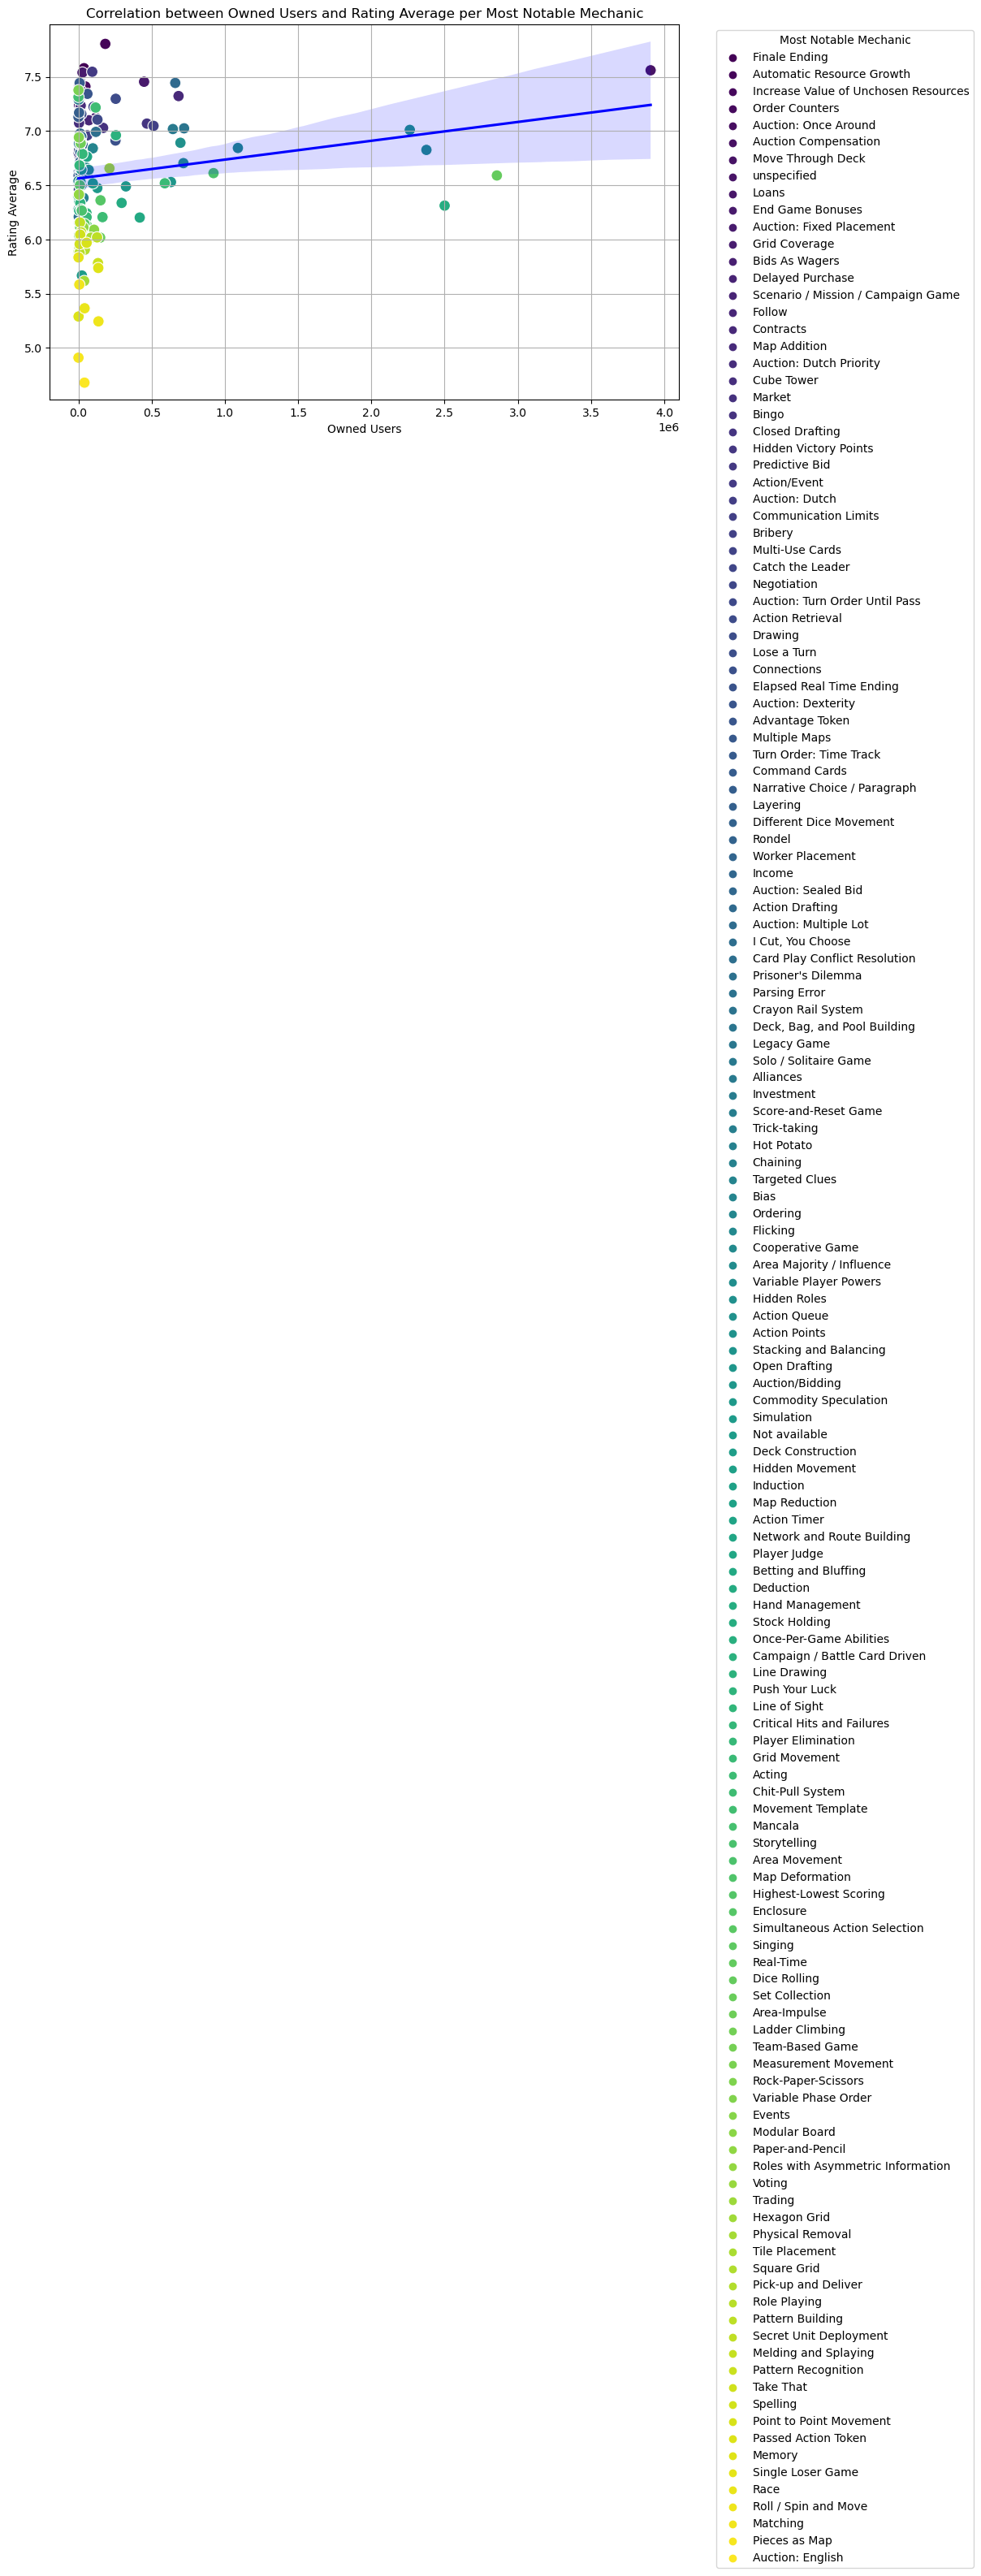

Pearson Correlation Coefficient: 0.1606264612621069
P-value: 0.051150024835788496
The correlation is not statistically significant.


(0.1606264612621069, 0.051150024835788496)

In [35]:
analyze_correlation(
    data=mech_stats, 
    x_col='Owned Users', 
    y_col='Rating Average', 
    hue_col='Most Notable Mechanic', 
    plot_title='Correlation between Owned Users and Rating Average per Most Notable Mechanic'
)

### BGG RANK ANALYSIS

The plot below shows a negative correlation between Owned Users and BGG Rank per domain. This means that the more owned users there are, BGG rank tends to lower (meaning they rank higher). 

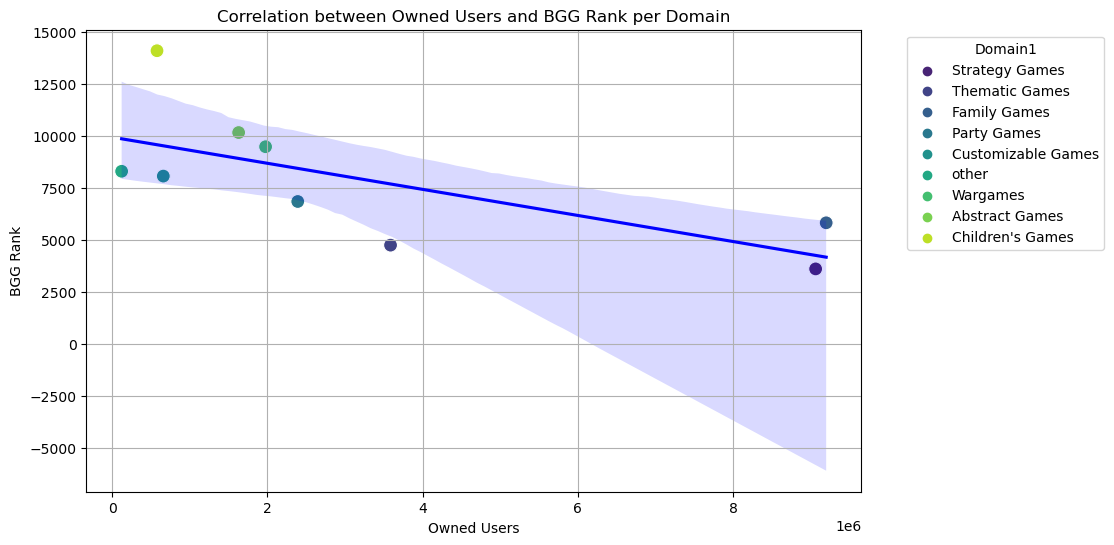

Pearson Correlation Coefficient: -0.6937862339708621
P-value: 0.03817129932438529
The correlation is statistically significant.


(-0.6937862339708621, 0.03817129932438529)

In [36]:
analyze_correlation(
    data=domain_stats, 
    x_col='Owned Users', 
    y_col='BGG Rank', 
    hue_col='Domain1', 
    plot_title='Correlation between Owned Users and BGG Rank per Domain'
)

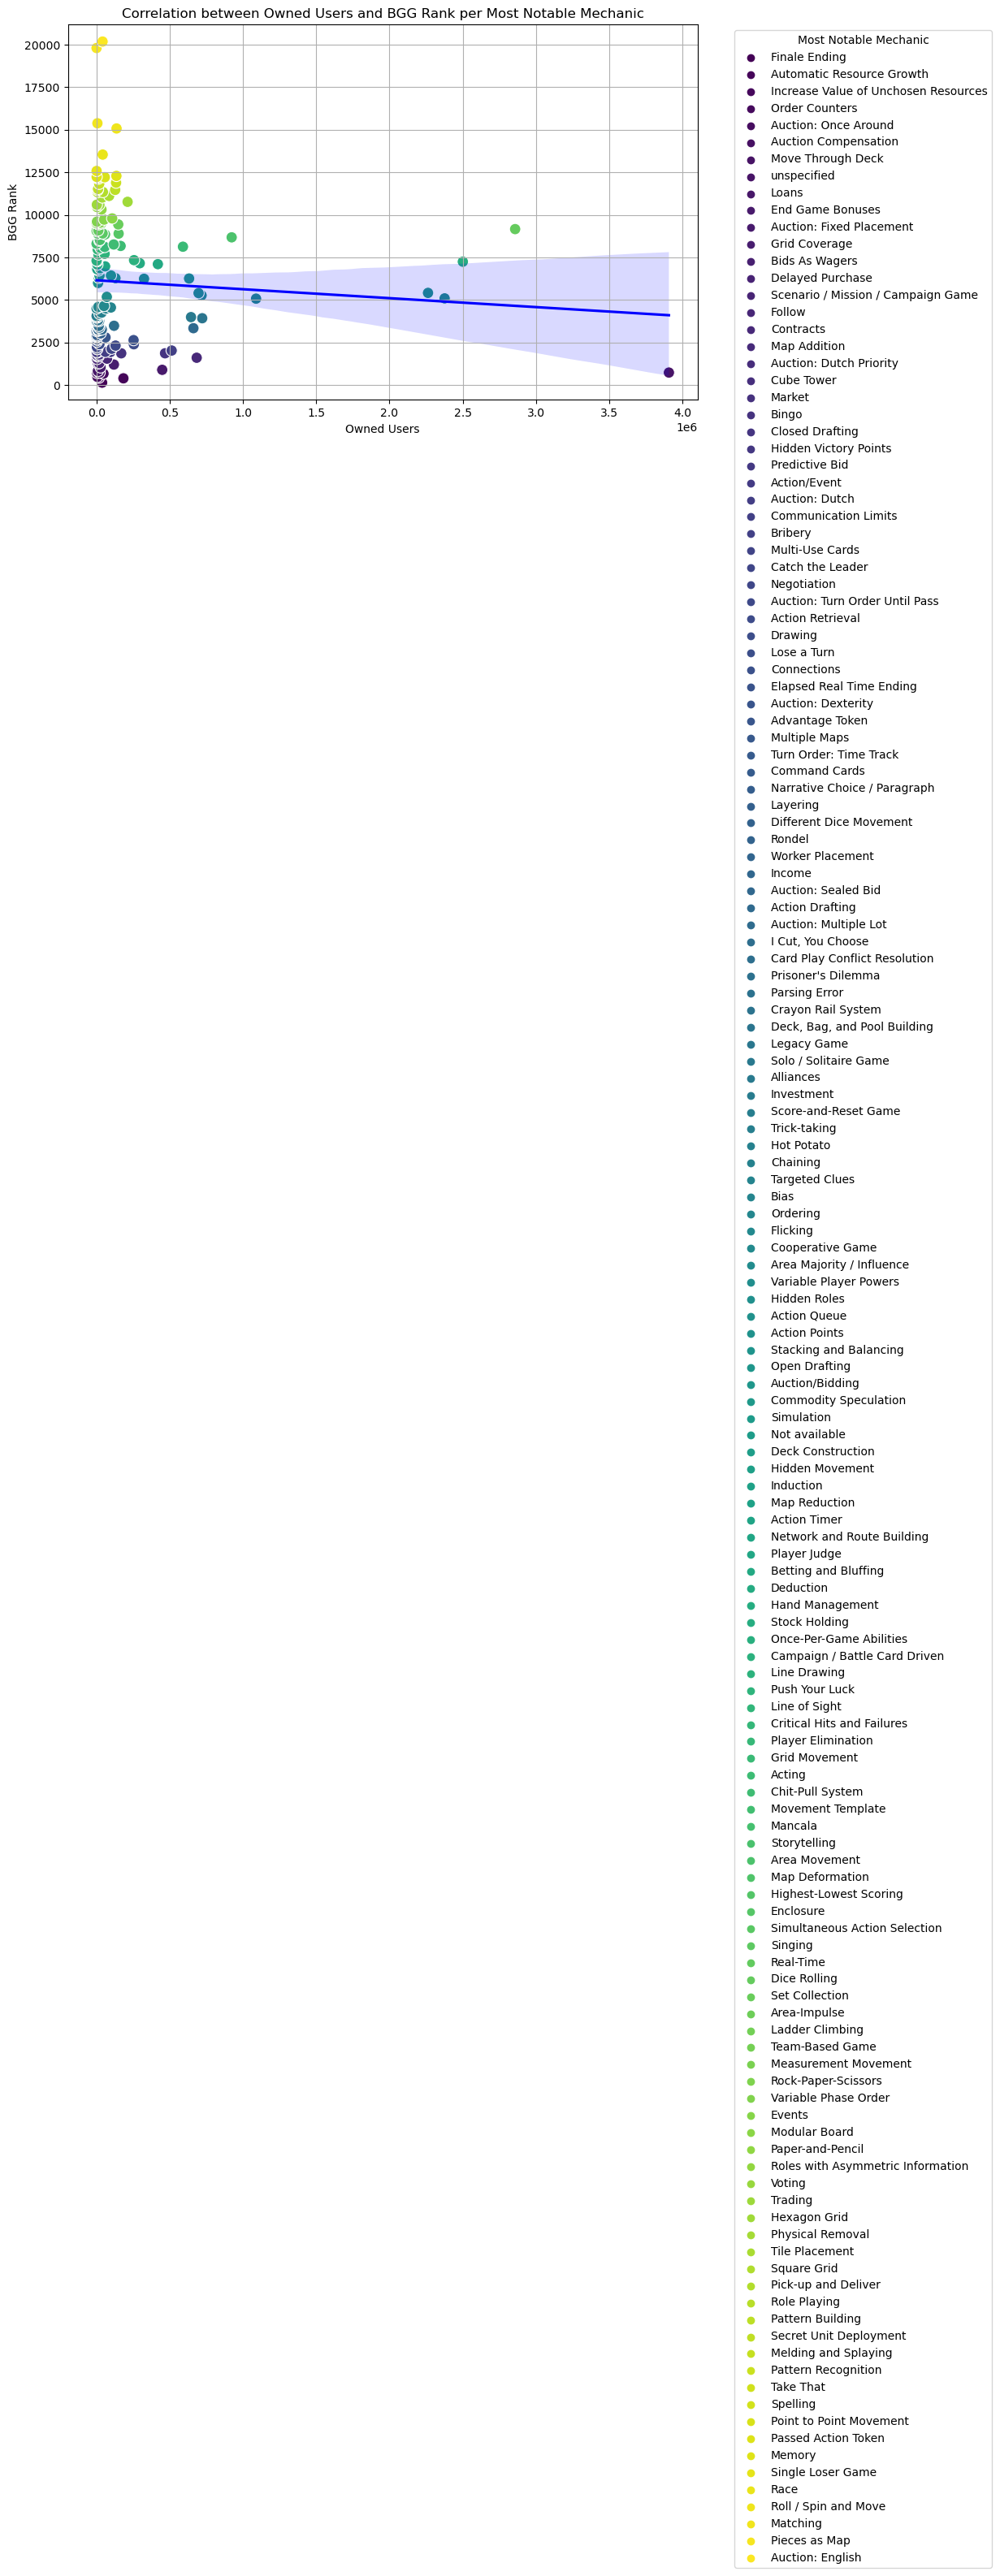

Pearson Correlation Coefficient: -0.0690482874940433
P-value: 0.40434741374412564
The correlation is not statistically significant.


(-0.0690482874940433, 0.40434741374412564)

In [37]:
analyze_correlation(
    data=mech_stats, 
    x_col='Owned Users', 
    y_col='BGG Rank', 
    hue_col='Most Notable Mechanic', 
    plot_title='Correlation between Owned Users and BGG Rank per Most Notable Mechanic'
)

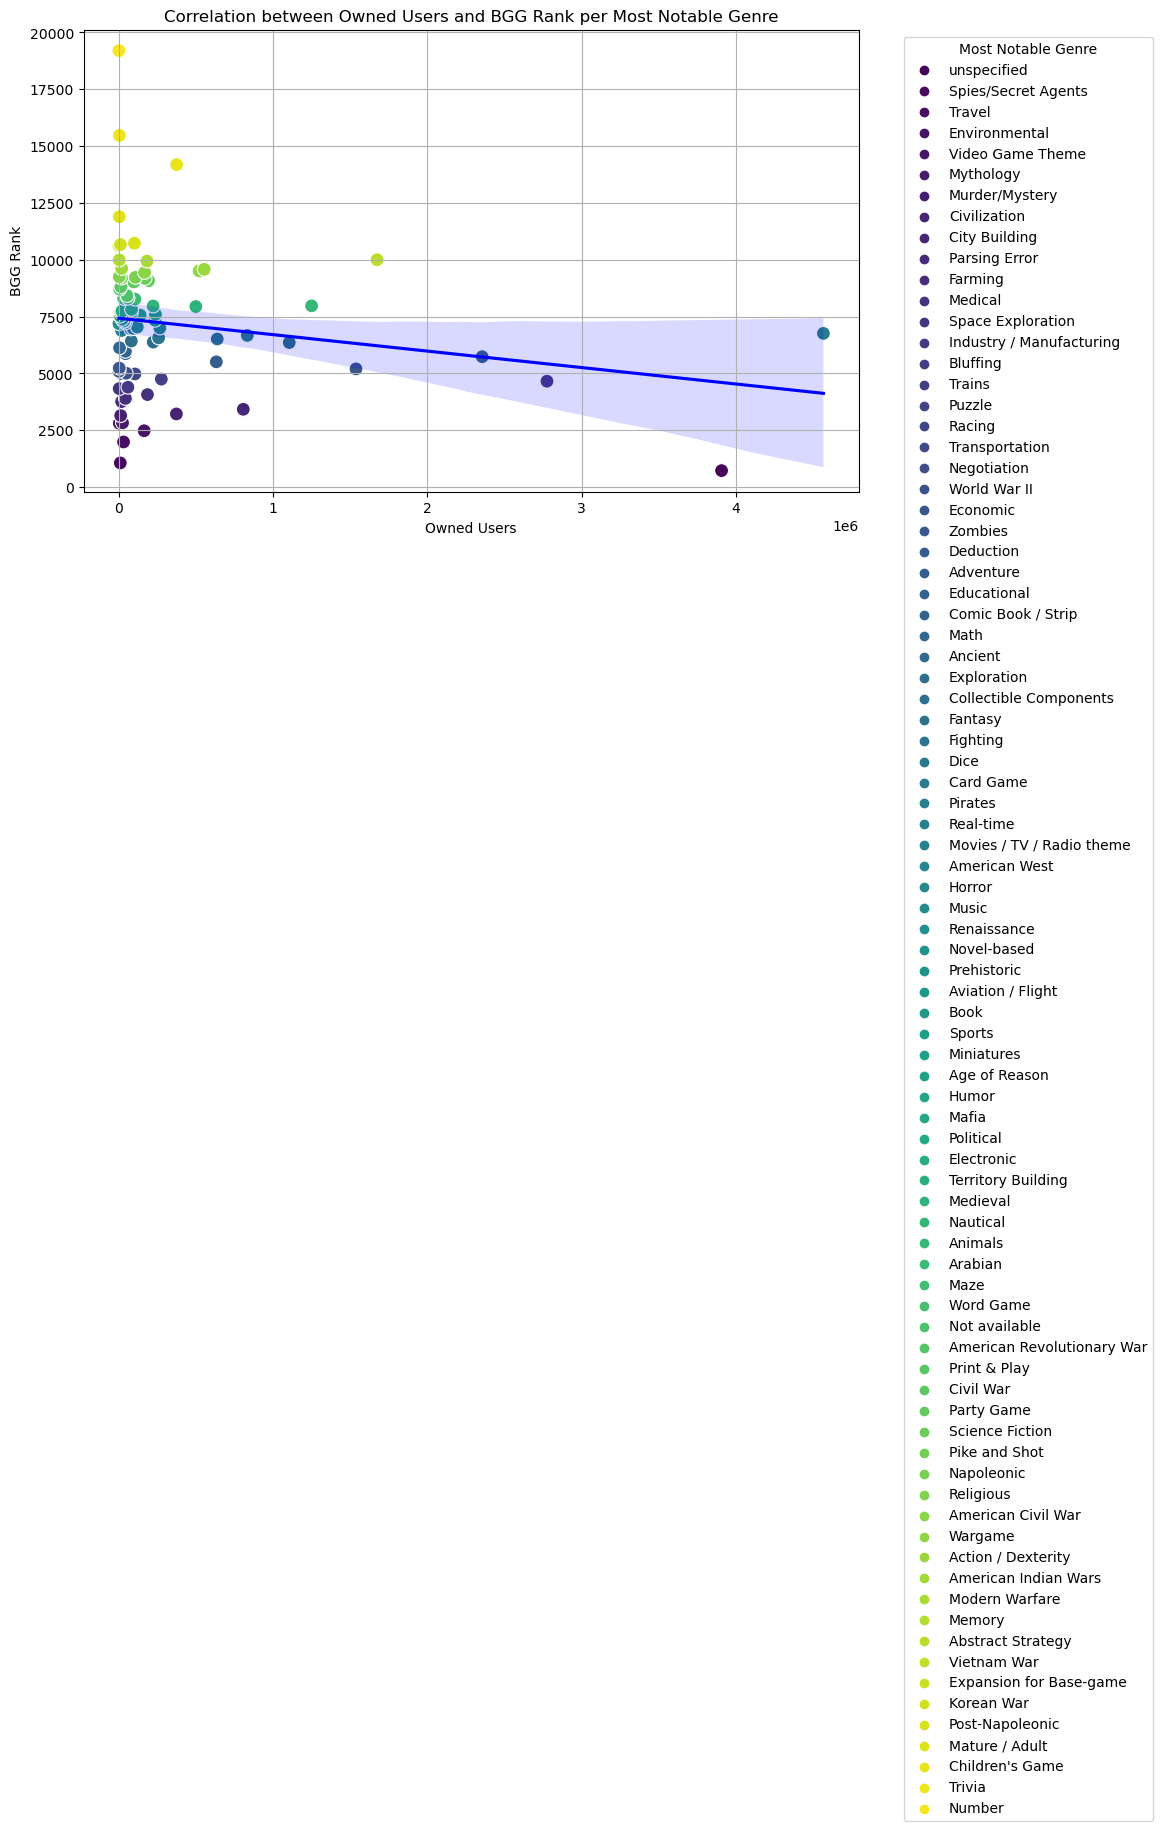

Pearson Correlation Coefficient: -0.19122455576694436
P-value: 0.08142804469180087
The correlation is not statistically significant.


(-0.19122455576694436, 0.08142804469180087)

In [38]:
analyze_correlation(
    data=genre_stats, 
    x_col='Owned Users', 
    y_col='BGG Rank', 
    hue_col='Most Notable Genre', 
    plot_title='Correlation between Owned Users and BGG Rank per Most Notable Genre'
)

### TOP 20% GAMES BASED ON BGG RANK

In [39]:
# Getting only top 20% of dataset based of BGG Rank and making dataframe
# Sort the DataFrame by 'BGG Rank' in ascending order
df_sorted = merged_df.sort_values(by='BGG Rank', ascending=True)

# Determine the number of rows that constitute the top 20%
top_20_percent = int(0.2 * len(df_sorted))

# Slice the top 20% of the DataFrame
top_20_df = df_sorted.head(top_20_percent)

# Now 'top_20_df' contains the top 20% based on 'BGG Rank'
print(top_20_df)

                                   Name  Min Players  Max Players  Play Time  \
0                            Gloomhaven          1.0          4.0      120.0   
1             Pandemic Legacy: Season 1          2.0          4.0       60.0   
2                     Brass: Birmingham          2.0          4.0      120.0   
3                     Terraforming Mars          1.0          5.0      120.0   
4     Twilight Imperium: Fourth Edition          3.0          6.0      480.0   
...                                 ...          ...          ...        ...   
2637                         Prosperity          2.0          4.0       60.0   
2638                       Mundus Novus          2.0          6.0       60.0   
2639   Pericles: The Peloponnesian Wars          1.0          4.0      360.0   
2641                          EastFront          2.0          2.0      240.0   
2642                        Canal Mania          2.0          5.0       90.0   

      Min Age  Users Rated  Rating Aver

In [40]:
len(top_20_df)

2228

In [41]:
domain_20_stats = top_20_df.groupby('Domain1').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='BGG Rank', ascending=True)

# Display the result
print(domain_20_stats)

                    Rating Average     BGG Rank  Owned Users  Users Rated
Domain1                                                                  
Strategy Games            7.386181   864.376260    7540045.0    5495923.0
Customizable Games        7.441273   910.109091     513423.0     306317.0
Abstract Games            6.752222   915.760684     984299.0     675331.0
Thematic Games            7.378061   944.724490    2522767.0    1524084.0
Party Games               7.075567  1069.536082    1278037.0     812924.0
Family Games              7.026581  1069.593750    6540806.0    4360534.0
Wargames                  7.477255  1102.588235     551349.0     308811.0
other                     6.423200  1118.540000      15714.0       7583.0
Children's Games          6.743200  1231.120000     131810.0      78164.0


In [42]:
genre_20_stats = top_20_df.groupby('Most Notable Genre').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='BGG Rank', ascending=True)

# Display the result
print(genre_20_stats)

                            Rating Average     BGG Rank  Owned Users  \
Most Notable Genre                                                     
unspecified                       7.556154   307.923077    3717978.0   
Math                              7.800000   546.000000       4685.0   
Travel                            6.990000   549.000000      30148.0   
Post-Napoleonic                   7.657143   629.285714      71907.0   
Movies / TV / Radio theme         6.679286   757.285714      46684.0   
...                                    ...          ...          ...   
Novel-based                       6.387143  1643.428571      16113.0   
American Revolutionary War        7.540000  1657.000000       2096.0   
Religious                         6.920000  1667.000000       2413.0   
Word Game                         6.280000  1810.000000      47733.0   
Pike and Shot                     7.320000  1858.000000       1898.0   

                            Users Rated  
Most Notable Genre   

In [43]:
mech_20_stats = top_20_df.groupby('Most Notable Mechanic').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='BGG Rank', ascending=True)

# Display the result
print(mech_20_stats)

                           Rating Average     BGG Rank  Owned Users  \
Most Notable Mechanic                                                 
Delayed Purchase                 8.140000    29.000000      16413.0   
Finale Ending                    7.580000   131.000000      38202.0   
unspecified                      7.556154   307.923077    3717978.0   
Automatic Resource Growth        7.804286   384.714286     183625.0   
Events                           7.380000   395.666667      25004.0   
...                                   ...          ...          ...   
Auction: Dexterity               6.910000  1824.000000       1705.0   
Spelling                         6.610000  1864.000000       3761.0   
Hidden Victory Points            7.165000  1909.000000       5943.0   
Take That                        6.830000  1960.000000       2083.0   
Physical Removal                 6.410000  1970.000000       5066.0   

                           Users Rated  
Most Notable Mechanic              

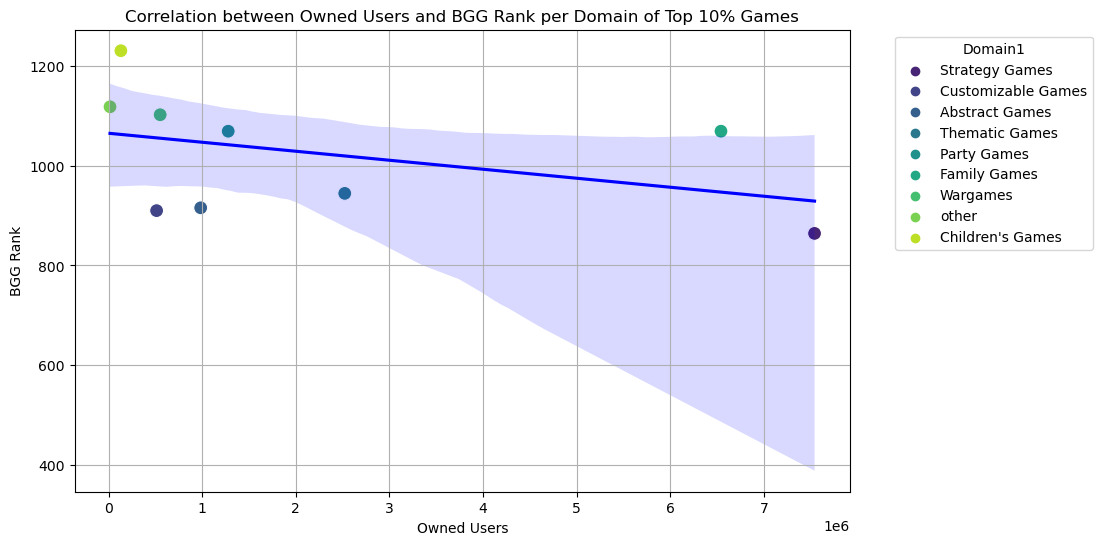

Pearson Correlation Coefficient: -0.420880332603026
P-value: 0.2592853167224633
The correlation is not statistically significant.


(-0.420880332603026, 0.2592853167224633)

In [44]:
analyze_correlation(
    data=domain_20_stats, 
    x_col='Owned Users', 
    y_col='BGG Rank', 
    hue_col='Domain1', 
    plot_title='Correlation between Owned Users and BGG Rank per Domain of Top 10% Games'
)

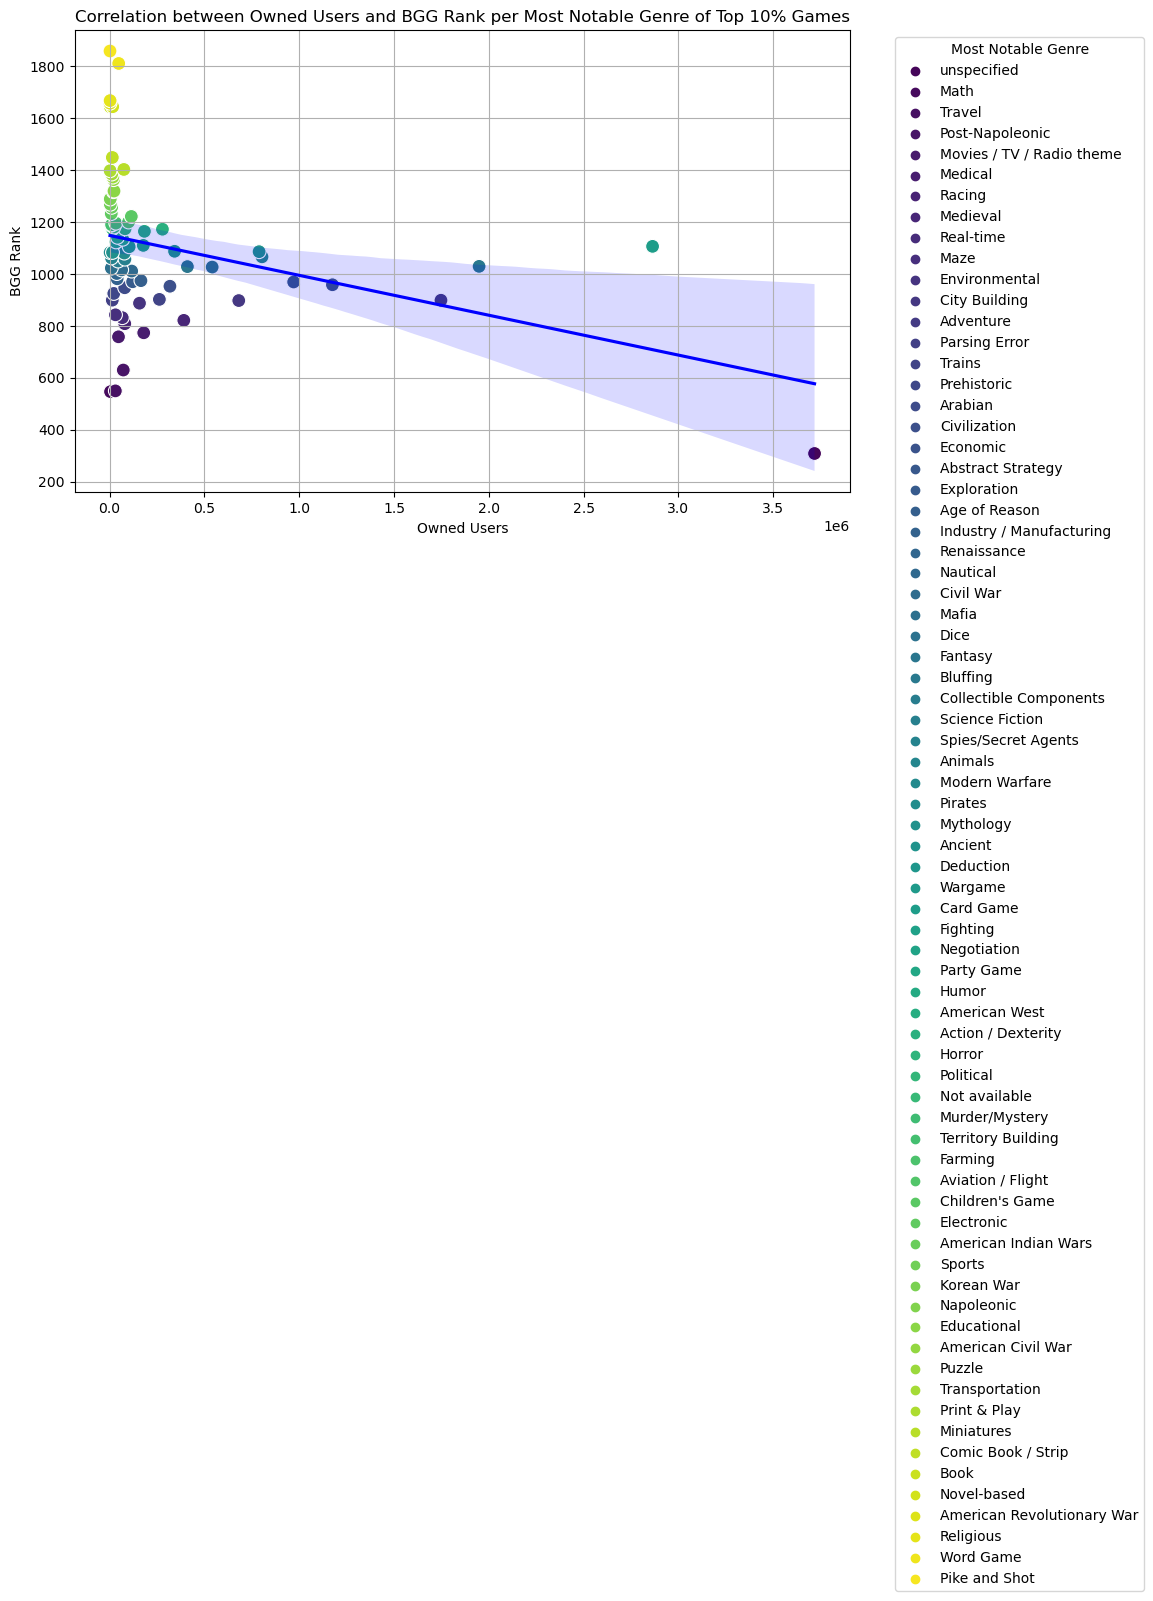

Pearson Correlation Coefficient: -0.35026312103540663
P-value: 0.002382673623016945
The correlation is statistically significant.


(-0.35026312103540663, 0.002382673623016945)

In [45]:
analyze_correlation(
    data=genre_20_stats, 
    x_col='Owned Users', 
    y_col='BGG Rank', 
    hue_col='Most Notable Genre', 
    plot_title='Correlation between Owned Users and BGG Rank per Most Notable Genre of Top 10% Games'
)

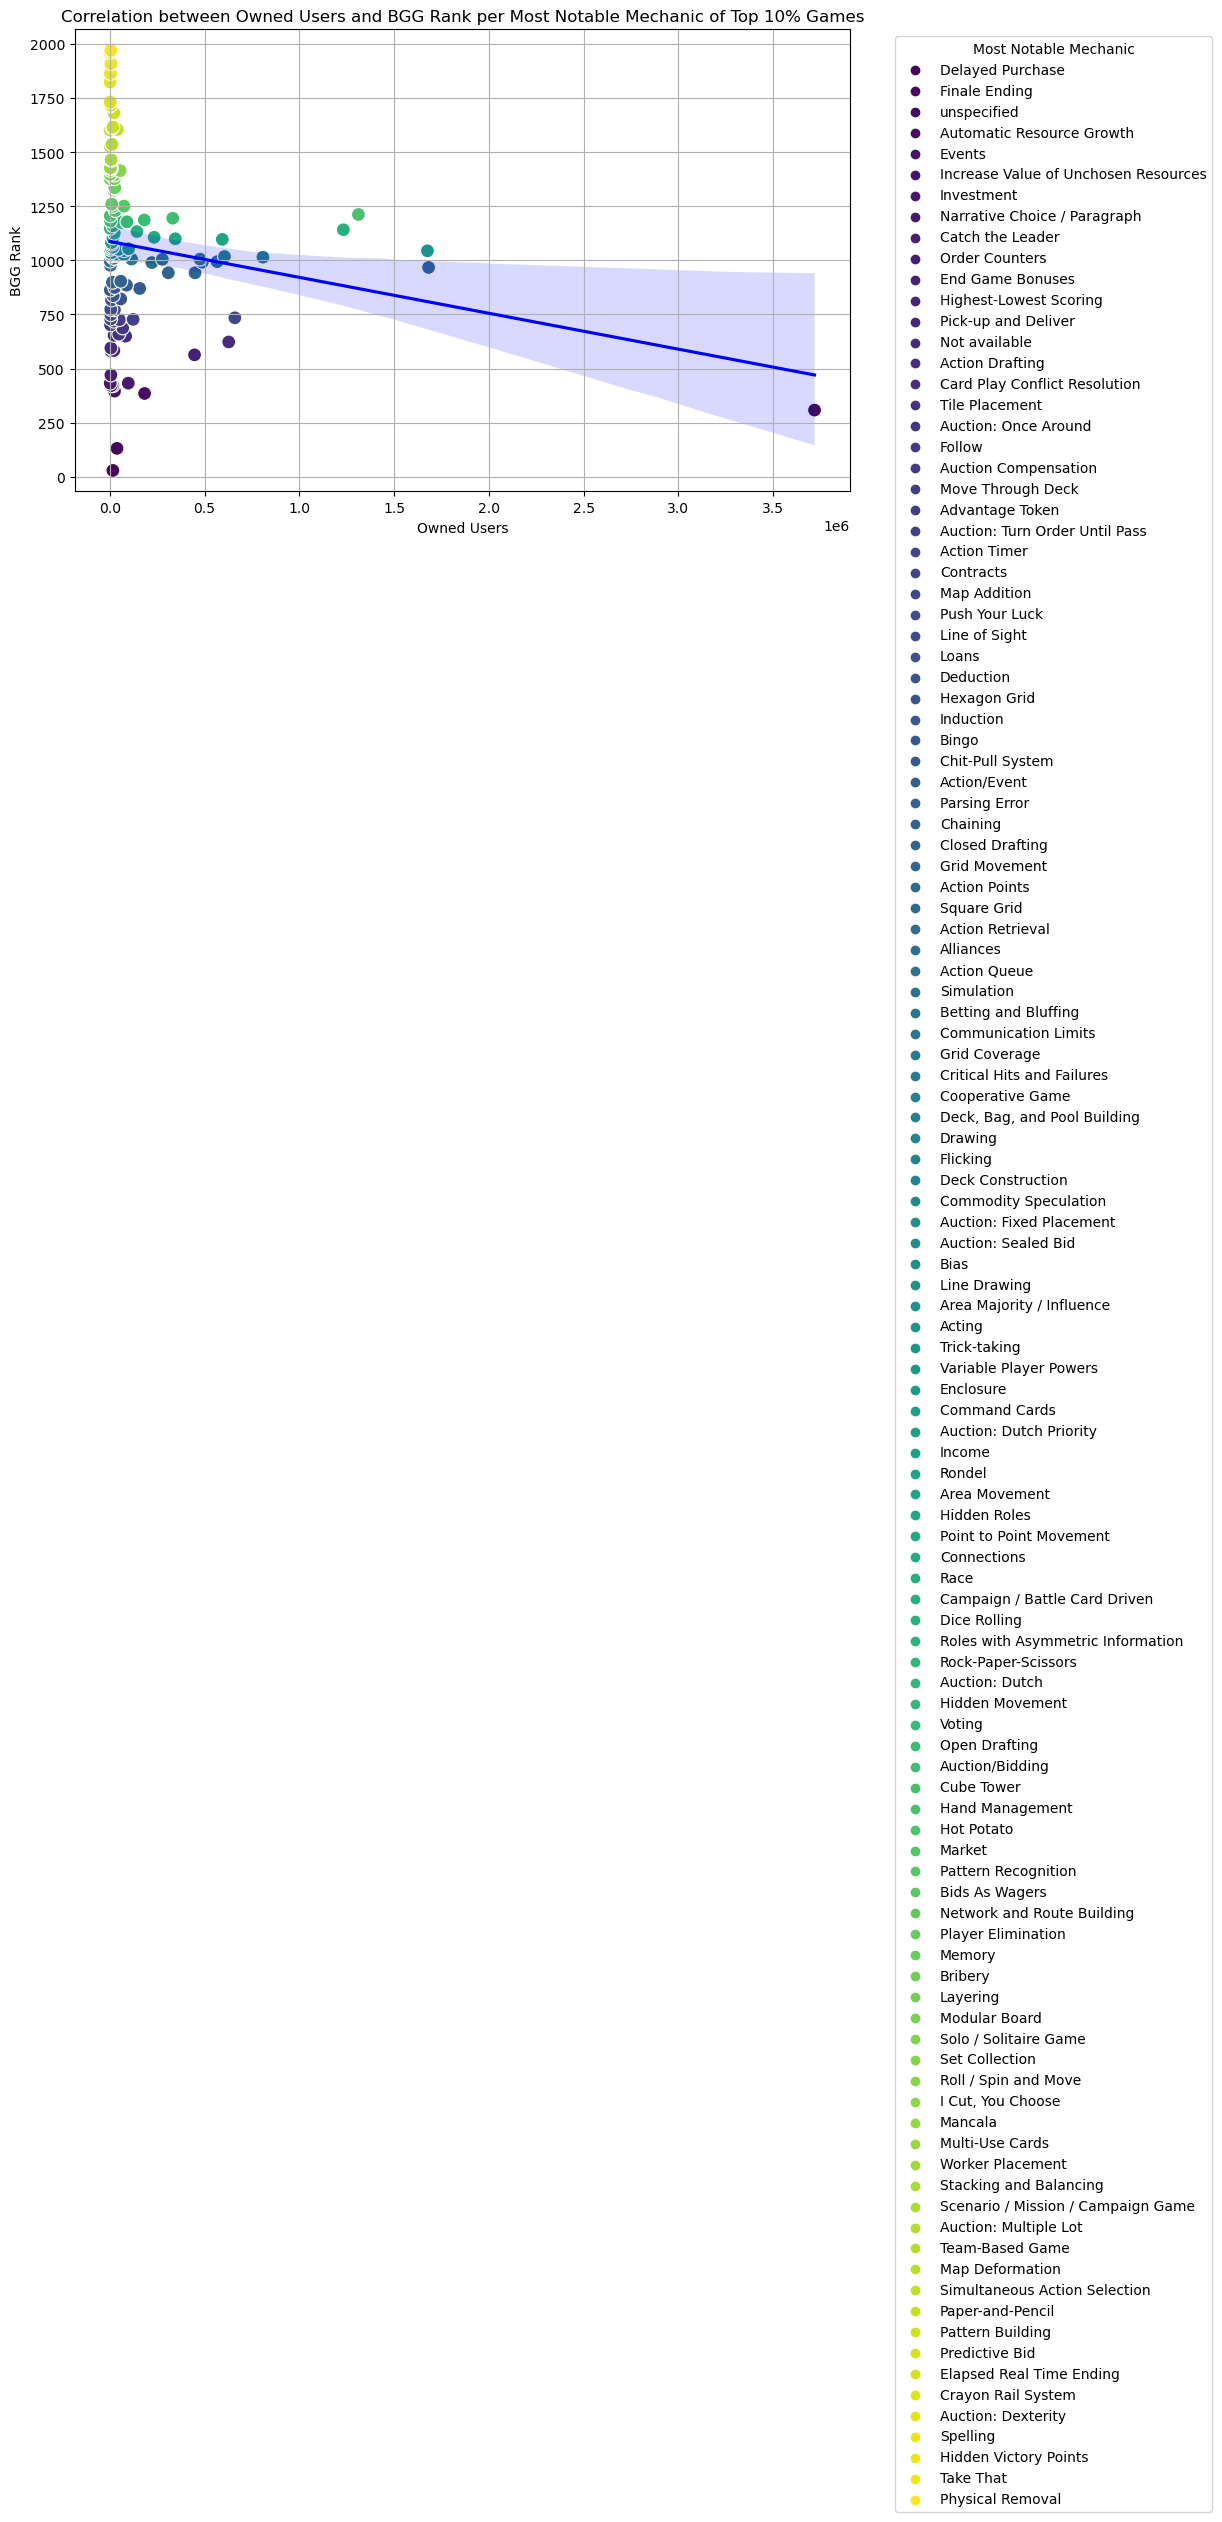

Pearson Correlation Coefficient: -0.19282871672264143
P-value: 0.03725502242805598
The correlation is statistically significant.


(-0.19282871672264143, 0.03725502242805598)

In [46]:
analyze_correlation(
    data=mech_20_stats, 
    x_col='Owned Users', 
    y_col='BGG Rank', 
    hue_col='Most Notable Mechanic', 
    plot_title='Correlation between Owned Users and BGG Rank per Most Notable Mechanic of Top 10% Games'
)